Sa se creeze si antreneze o retea de tip convolutional pentru setul de date [CIFAR100](https://www.cs.toronto.edu/~kriz/cifar.html). Intrarea este RGB, de forma 32 x 32 x 3. 

Cerinte:
1. Efectuati minim 50 de epoci de instruire. 
1. Reprezentati grafic evolutia functiei de cost si a acuratetei, masurate pe setul de antrenare si de validare, la finalul fiecarei epoci.
1. Acuratetea unui model neantrenat este de in medie 1% (se decide aleator o clasa pentru fiecare input). Modelul vostru va trebui sa ajunga mult peste acest prag de baza. 
1. Odata gasit arhitectura care performeaza peste 1%, incercati 3 valori diferite pentru hiperparametrul learning rate. Modelul va fi antrenat pe 45000 de imagini alese aleator din setul de antrenare si validat pe restul de 5000 imagini din setul de antrenare. Acel LR care produce cea mai buna acuratete pe setul de validare va fi folosit pentru antrenarea peste cele 45000 imagini de antrenare + 5000 imagini de testare si in final testat pe setul de testare de 10000 de imagini. Setul de testare nu se va folosi in etapa de antrenare sau de validare (cautare de LR optimal). 


Nota: pentru desenarea in timp real a graficelor puteti folosi tensorboard [https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html), [https://towardsdatascience.com/a-complete-guide-to-using-tensorboard-with-pytorch-53cb2301e8c3](https://towardsdatascience.com/a-complete-guide-to-using-tensorboard-with-pytorch-53cb2301e8c3). Reprezentarea in timp real e utila, pentru a putea opri experimentele care nu arata o scadere a loss-ului dupa primele 5 epoci.

## Import de pachete

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
import torch.utils.data
from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device: torch.device = torch.device('cuda')
else:
    device: torch.device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

KeyboardInterrupt: 

In [3]:
!pip install torch-summary
from torchsummary import summary

!pip install tensorboard
from torch.utils.tensorboard import SummaryWriter

## Pregatire dataset, dataloader

In [13]:
# se poate ajusta dimensiunea batchului
batch_size: int = 256
train_dataset = datasets.CIFAR100('./data', 
                               train=True, 
                               download=False, 
                               transform=transforms.ToTensor())

assert len(train_dataset) == 50000

train_lr_dataset, valid_lr_dataset = torch.utils.data.random_split(train_dataset, [45000, 5000])

test_dataset = datasets.CIFAR100('./data', 
                                train=False, 
                                transform=transforms.ToTensor())

assert len(test_dataset) == 10000

In [14]:
train_loader: torch.utils.data.DataLoader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader: torch.utils.data.DataLoader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)
    
lr_train_loader: torch.utils.data.DataLoader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

lr_test_loader: torch.utils.data.DataLoader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

Nota: daca celula de plot produce eroare, atunci se foloseste workaround de la [https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial](https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial):"

In [15]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [16]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break


X_train: torch.Size([256, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([256]) type: torch.LongTensor


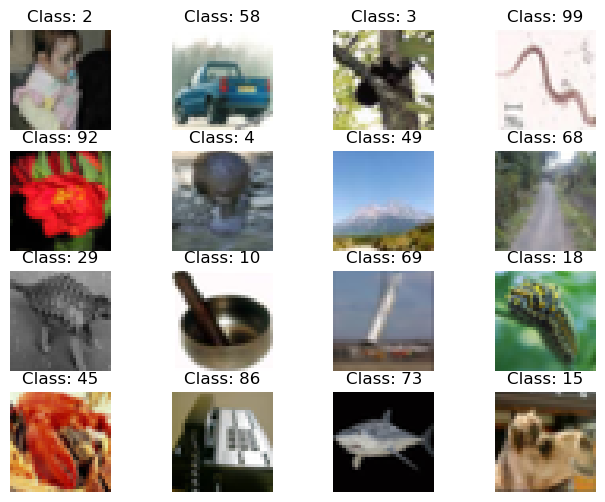

In [17]:
pltsize=1
plt.figure(figsize=(8, 6))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(3,32,32).transpose(1,2,0))
    plt.title('Class: '+str(y_train[i].item()))

## Functii: antrenare, validare, desenare

Definiti in mod convenabil functii de antrenare si de validare. Puteti reutiliza cod din notebook-urile anterioare. 

In [18]:
import matplotlib.pyplot as plt

def train(model: nn.Module,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          train_loader: torch.utils.data.DataLoader,
          epoch: int,
          device: torch.device,
          log_interval: int = 200) -> Tuple[float, float]:
    model.train()
    train_loss: float = 0
    correct: int = 0
    total: int = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs: torch.Tensor = model(inputs)
        loss: torch.Tensor = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(inputs)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.2f}%)]\tLoss: {loss.item():.4f}')
    
    train_loss /= len(train_loader)
    accuracy: float = 100. * correct / total
    return train_loss, accuracy

In [19]:
@torch.no_grad()
def validate(model: nn.Module,
             criterion: nn.Module,
             test_loader: torch.utils.data.DataLoader,
             device: torch.device) -> Tuple[float, float]:
    model.eval()
    test_loss: float = 0
    correct: int = 0
    total: int = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs: torch.Tensor = model(inputs)
            loss: torch.Tensor = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_loss /= len(test_loader)
    accuracy: float = 100. * correct / total
    return test_loss, accuracy

In [20]:
def train_loop(model: nn.Module,
               optimizer: optim.Optimizer,
               criterion: nn.Module,
               train_loader: torch.utils.data.DataLoader,
               test_loader: torch.utils.data.DataLoader,
               device: torch.device,
               epochs: int,
               log_interval: int = 1) -> None:
    train_losses: List[float] = []
    train_accuracies: List[float] = []
    test_losses: List[float] = []
    test_accuracies: List[float] = []
    
    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader, epoch, device)
        test_loss, test_accuracy = validate(model, criterion, test_loader, device)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        if epoch % log_interval == 0:
            print(f'\nEpoch {epoch}:')
            print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%')
            print(f'Validation Loss: {test_loss:.4f} | Validation Accuracy: {test_accuracy:.2f}%')
    
    # Plotting
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train')
    plt.plot(range(1, epochs + 1), test_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

## Definire model si gasire de learning rate optimal

In [21]:
# Define the SimpleNet architecture
class SimpleNet(nn.Module):
    def __init__(self, activation='relu')-> None:
        super(SimpleNet, self).__init__()
        # Input shape: 32 x 32 x 3

        self.conv1: nn.Conv2d = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        # Output shape: 32 x 32 x 32
        self.bn1: nn.BatchNorm2d = nn.BatchNorm2d(num_features=32)
        self.pool2: nn.MaxPool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Output shape: 16 x 16 x 32

        self.conv3: nn.Conv2d = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Output shape: 16 x 16 x 64
        self.bn3: nn.BatchNorm2d = nn.BatchNorm2d(num_features=64)
        self.pool4: nn.MaxPool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Output shape: 8 x 8 x 64

        self.conv5: nn.Conv2d = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        # Output shape: 8 x 8 x 128
        self.bn5: nn.BatchNorm2d = nn.BatchNorm2d(num_features=128)
        self.pool6: nn.MaxPool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Output shape: 4 x 4 x 128

        self.avgpool: nn.AdaptiveAvgPool2d = nn.AdaptiveAvgPool2d((4, 4))  # Dynamic adaptive average pooling

        self.fc7: nn.Linear = nn.Linear(in_features=4 * 4 * 128, out_features=512)
        self.bn7: nn.BatchNorm1d = nn.BatchNorm1d(num_features=512)

        self.fc8: nn.Linear = nn.Linear(in_features=512, out_features=100)

        if activation == 'relu':
            self.activation: nn.Module = nn.ReLU(inplace=True)
        elif activation == 'sigmoid':
            self.activation: nn.Module = nn.Sigmoid()
        else:
            self.activation: nn.Module = nn.Tanh()

    def forward(self, x) -> torch.Tensor:
        # x has shape (batch_size, 3, 32, 32)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.activation(x)
        x = self.pool6(x)

        #x = self.avgpool(x)  # Apply adaptive average pooling

        x = x.view(x.size(0), -1)
        x = self.fc7(x)
        x = self.bn7(x)
        x = self.activation(x)

        x = self.fc8(x)

        return x

In [24]:
#rulam model neantrenat pentru a verifica acuratetea si loss-ul initiale

simpleModel: SimpleNet = SimpleNet(activation='relu').to(device)
validate(simpleModel, nn.CrossEntropyLoss(), test_loader, device)

(4.605680680274963, 1.0)


Training with learning rate: 0.0001
Train Epoch: 1 [0/50000 (0.00%)]	Loss: 4.6962

Epoch 1:
Train Loss: 4.5898 | Train Accuracy: 2.26%
Validation Loss: 4.4923 | Validation Accuracy: 3.97%
Train Epoch: 2 [0/50000 (0.00%)]	Loss: 4.5004

Epoch 2:
Train Loss: 4.4113 | Train Accuracy: 5.91%
Validation Loss: 4.3480 | Validation Accuracy: 7.03%
Train Epoch: 3 [0/50000 (0.00%)]	Loss: 4.3180

Epoch 3:
Train Loss: 4.2843 | Train Accuracy: 8.37%
Validation Loss: 4.2403 | Validation Accuracy: 8.71%
Train Epoch: 4 [0/50000 (0.00%)]	Loss: 4.2463

Epoch 4:
Train Loss: 4.1890 | Train Accuracy: 10.06%
Validation Loss: 4.1663 | Validation Accuracy: 10.07%
Train Epoch: 5 [0/50000 (0.00%)]	Loss: 4.1241

Epoch 5:
Train Loss: 4.1146 | Train Accuracy: 11.26%
Validation Loss: 4.0995 | Validation Accuracy: 11.09%
Train Epoch: 6 [0/50000 (0.00%)]	Loss: 4.1583

Epoch 6:
Train Loss: 4.0531 | Train Accuracy: 12.39%
Validation Loss: 4.0481 | Validation Accuracy: 12.13%
Train Epoch: 7 [0/50000 (0.00%)]	Loss: 3.9859

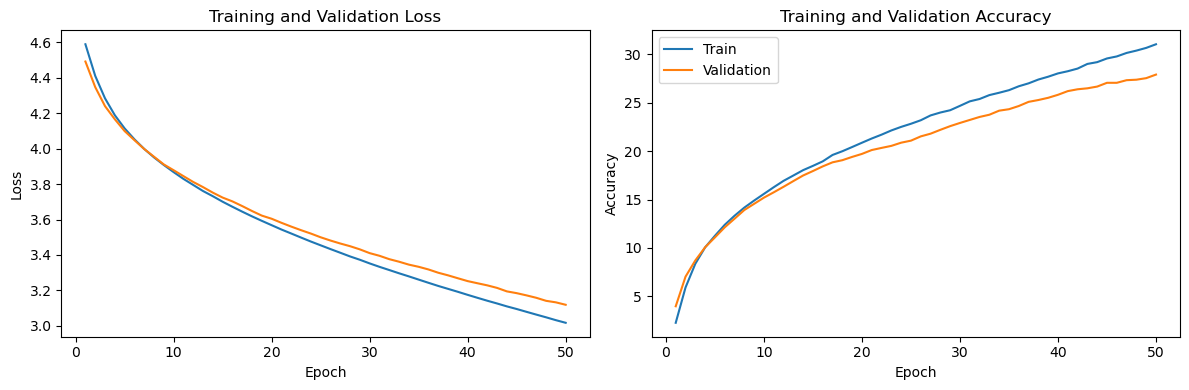


Training with learning rate: 0.001
Train Epoch: 1 [0/50000 (0.00%)]	Loss: 4.6605

Epoch 1:
Train Loss: 4.1999 | Train Accuracy: 8.94%
Validation Loss: 3.9009 | Validation Accuracy: 13.73%
Train Epoch: 2 [0/50000 (0.00%)]	Loss: 3.9605

Epoch 2:
Train Loss: 3.7362 | Train Accuracy: 17.29%
Validation Loss: 3.6439 | Validation Accuracy: 18.48%
Train Epoch: 3 [0/50000 (0.00%)]	Loss: 3.5507

Epoch 3:
Train Loss: 3.4959 | Train Accuracy: 21.44%
Validation Loss: 3.4462 | Validation Accuracy: 22.04%
Train Epoch: 4 [0/50000 (0.00%)]	Loss: 3.4530

Epoch 4:
Train Loss: 3.3110 | Train Accuracy: 24.89%
Validation Loss: 3.3002 | Validation Accuracy: 24.58%
Train Epoch: 5 [0/50000 (0.00%)]	Loss: 3.2214

Epoch 5:
Train Loss: 3.1511 | Train Accuracy: 27.86%
Validation Loss: 3.1888 | Validation Accuracy: 26.51%
Train Epoch: 6 [0/50000 (0.00%)]	Loss: 3.1393

Epoch 6:
Train Loss: 3.0103 | Train Accuracy: 30.45%
Validation Loss: 3.0525 | Validation Accuracy: 29.04%
Train Epoch: 7 [0/50000 (0.00%)]	Loss: 2.

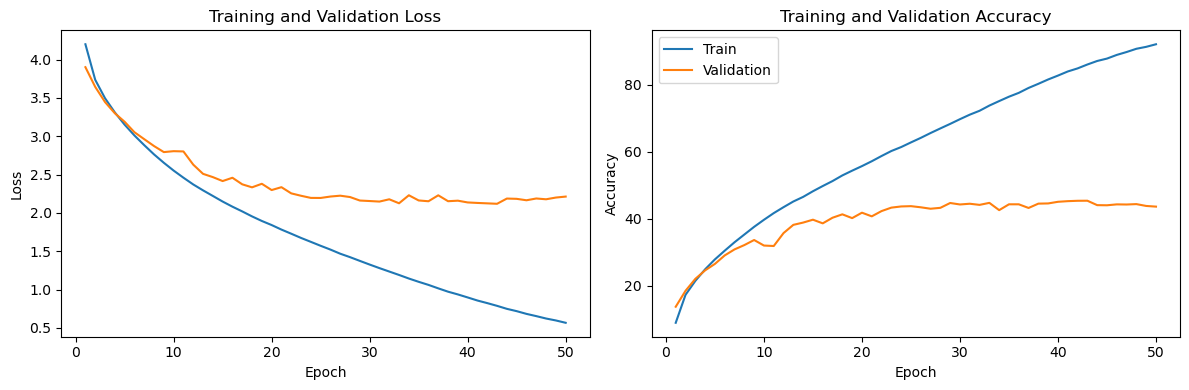


Training with learning rate: 0.1
Train Epoch: 1 [0/50000 (0.00%)]	Loss: 4.6790

Epoch 1:
Train Loss: 3.1263 | Train Accuracy: 24.02%
Validation Loss: 3.5361 | Validation Accuracy: 19.74%
Train Epoch: 2 [0/50000 (0.00%)]	Loss: 2.4411

Epoch 2:
Train Loss: 2.2295 | Train Accuracy: 41.64%
Validation Loss: 2.4436 | Validation Accuracy: 38.07%
Train Epoch: 3 [0/50000 (0.00%)]	Loss: 1.6332

Epoch 3:
Train Loss: 1.7654 | Train Accuracy: 52.47%
Validation Loss: 2.2145 | Validation Accuracy: 44.03%
Train Epoch: 4 [0/50000 (0.00%)]	Loss: 1.2709

Epoch 4:
Train Loss: 1.3966 | Train Accuracy: 61.05%
Validation Loss: 2.2189 | Validation Accuracy: 44.17%
Train Epoch: 5 [0/50000 (0.00%)]	Loss: 1.0403

Epoch 5:
Train Loss: 1.0563 | Train Accuracy: 70.07%
Validation Loss: 2.2312 | Validation Accuracy: 46.26%
Train Epoch: 6 [0/50000 (0.00%)]	Loss: 0.6418

Epoch 6:
Train Loss: 0.7457 | Train Accuracy: 78.74%
Validation Loss: 2.3922 | Validation Accuracy: 45.65%
Train Epoch: 7 [0/50000 (0.00%)]	Loss: 0.3

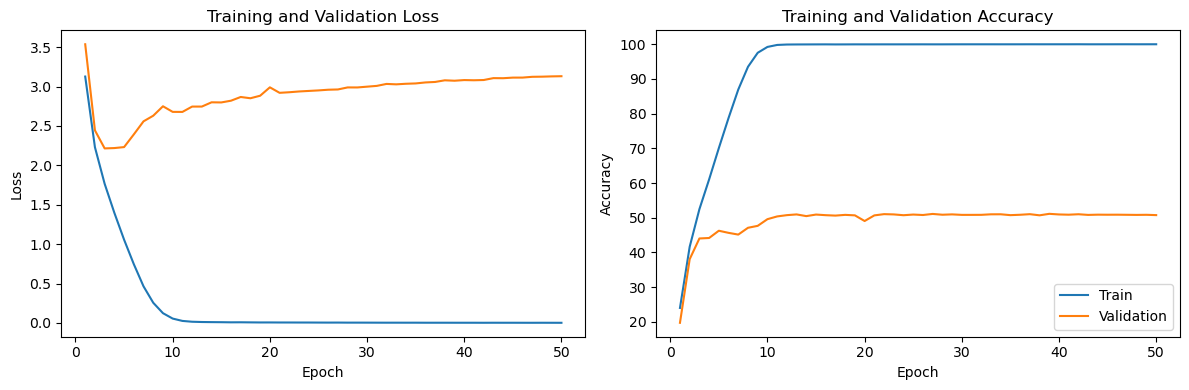


Best learning rate: 0.1


In [25]:
# Define the criterion and optimizer
criterion: nn.Module = nn.CrossEntropyLoss()
learning_rates: List[float] = [0.0001, 0.001, 0.1]
best_accuracy: float = 0
best_lr: float = 0
    
for lr in learning_rates:
    model: SimpleNet = SimpleNet(activation='relu').to(device)
    optimizer: optim.Optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    print(f"\nTraining with learning rate: {lr}")
    
    # Train the model
    train_loop(model, optimizer, criterion, lr_train_loader, lr_test_loader, device, epochs=50, log_interval=1)
    
    # Validate the model on the validation set
    _, accuracy = validate(model, criterion, test_loader, device)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_lr = lr

print(f"\nBest learning rate: {best_lr}")

Train Epoch: 1 [0/50000 (0.00%)]	Loss: 4.7104

Epoch 1:
Train Loss: 3.0933 | Train Accuracy: 24.48%
Validation Loss: 3.0193 | Validation Accuracy: 26.45%
Train Epoch: 2 [0/50000 (0.00%)]	Loss: 2.4496

Epoch 2:
Train Loss: 2.1930 | Train Accuracy: 42.39%
Validation Loss: 2.6057 | Validation Accuracy: 35.41%
Train Epoch: 3 [0/50000 (0.00%)]	Loss: 1.6455

Epoch 3:
Train Loss: 1.7589 | Train Accuracy: 52.05%
Validation Loss: 2.2305 | Validation Accuracy: 42.65%
Train Epoch: 4 [0/50000 (0.00%)]	Loss: 1.2893

Epoch 4:
Train Loss: 1.4058 | Train Accuracy: 60.77%
Validation Loss: 2.5274 | Validation Accuracy: 40.02%
Train Epoch: 5 [0/50000 (0.00%)]	Loss: 1.0583

Epoch 5:
Train Loss: 1.0875 | Train Accuracy: 69.19%
Validation Loss: 2.2816 | Validation Accuracy: 44.42%
Train Epoch: 6 [0/50000 (0.00%)]	Loss: 0.6828

Epoch 6:
Train Loss: 0.7582 | Train Accuracy: 78.35%
Validation Loss: 2.4740 | Validation Accuracy: 44.41%
Train Epoch: 7 [0/50000 (0.00%)]	Loss: 0.4382

Epoch 7:
Train Loss: 0.4840 |

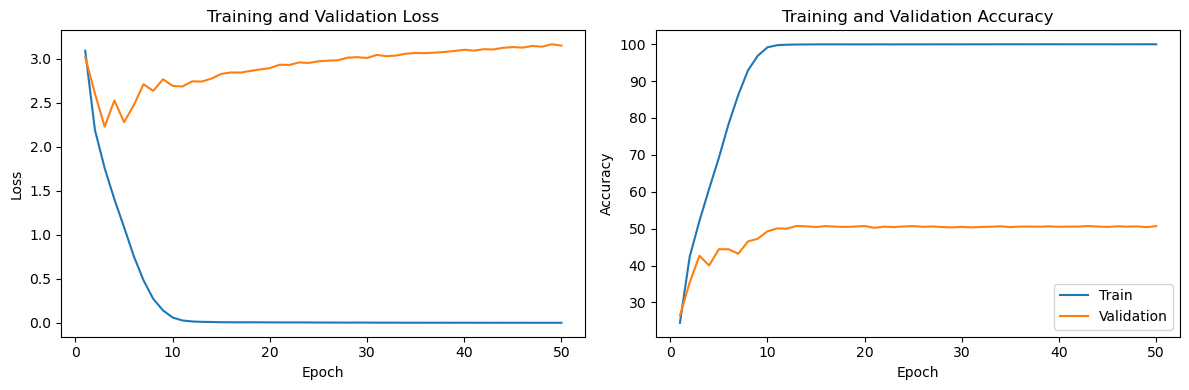

In [26]:
modelFin = SimpleNet(activation='relu').to(device)
optimizer = optim.SGD(modelFin.parameters(), lr=best_lr, momentum=0.9)

train_loop(modelFin, optimizer, criterion, train_loader, test_loader, device, epochs=50, log_interval=1)
